<center>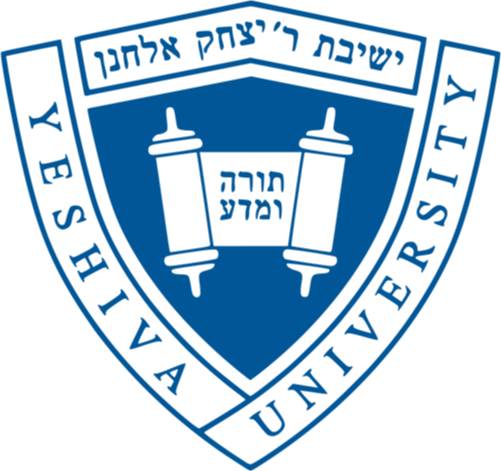</center>

<h1 style='text-align: center;'>Katz School of Science and Health</h1>
<h1 style='text-align: center;'>AIM 5007 Neural Networks and Deep Learning</h1>
<p>
<h2 style='text-align: center;'>Project 2</h1>
<br><br>

<h3 style='text-align: center;'>Radek Jan Holik</h3>
<br>
<br>

# Package import

In [1]:
# Import some important packages here
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import cv2
import torchvision
from torchvision import models, transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from IPython.display import clear_output
%matplotlib inline
from torchvision.ops import box_iou
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import random
from torchvision.transforms.functional import to_pil_image


from datetime import datetime, timedelta
from timeit import default_timer as timer

import warnings
warnings.filterwarnings("ignore")

# ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
if torch.cuda.is_available():
  print("CUDA available. Using GPU acceleration.")
  print(f"Number of CUDA devices : {torch.cuda.device_count()}")
  print(f"Device name : {torch.cuda.get_device_name(0)}")
  device = "cuda:0"
else:
  print("CUDA is NOT available. Using CPU for training.")
  device = "cpu"

CUDA available. Using GPU acceleration.
Number of CUDA devices : 1
Device name : NVIDIA GeForce RTX 3090


# 1. Build an object detection model using pytorch

In [3]:
class MyObjectDetector(nn.Module):
    def __init__(self, num_classes, image_size = (270, 480)):
        super(MyObjectDetector, self).__init__()
        # Maximum width (or the width of your input image)
        # Maximum height (or the height of your input image)
        self.max_height = image_size[0]
        self.max_width = image_size[1]

        # Load the pretrained ResNet101 model for feature extraction
        self.original_model = models.resnet101(pretrained = True)
        
        # Remove the last layer to use the features before classification
        self.feature_extractor = nn.Sequential(*list(self.original_model.children())[:-1])

        # Fully connected layer for classification
        self.classifier = nn.Sequential(
            nn.Linear(self.original_model.fc.in_features, num_classes),
            # nn.Softmax(dim=1)
        )

        # Fully connected layer for bounding box regression
        self.bbox_regressor = nn.Sequential(
            nn.Linear(self.original_model.fc.in_features, 4),
        )

    def forward(self, x):
        max_height, max_width = self.max_height, self.max_width

        # Extract features from the input image
        x = self.feature_extractor(x)

        # Flatten the features
        x = x.view(x.size(0), -1)

        # Classify the object
        class_output = self.classifier(x)

        # Predict the bounding box coordinates
        raw_bbox_coords = self.bbox_regressor(x)

        # Apply the activation function to the width and height
        xmin_ymin = raw_bbox_coords[:, :2]
        width_height = F.relu(raw_bbox_coords[:, 2:]) * torch.tensor([max_width, max_height], device=raw_bbox_coords.device)

        xmax_ymax = xmin_ymin + width_height
        bbox_coords = torch.cat((xmin_ymin, xmax_ymax), dim=1)
        
        # Return prob. of class and bounding boxes
        return class_output, bbox_coords

In [4]:
num_classes = 61
image_size = (270, 480)

In [6]:
# Initialize the model

# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True).to(device)
model = MyObjectDetector(num_classes, image_size).to(device)

print(model)

MyObjectDetector(
  (original_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequen

In [7]:
# Model Parameters
total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} model parameters")

44,682,345 model parameters


In [8]:
print(f"Is my model in GPU? : {next(model.parameters()).is_cuda}\n")

# GPU memory cache size
if torch.cuda.is_available():
    print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

Is my model in GPU? : True

The allocated memory in the GPU for the model : 174.348MB


In [8]:
def test_model(model, image_path):
    # Read the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize the image to be at least 299x299
    height, width, _ = image.shape
    min_dim = 299
    
    scale_w = min_dim / width
    scale_h = min_dim / height
    scale = max(scale_w, scale_h)

    new_width = int(scale * width)
    new_height = int(scale * height)

    image = cv2.resize(image, (new_width, new_height), interpolation = cv2.INTER_LINEAR)

    # Normalize the image
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean = [0.4291, 0.3697, 0.3113], std = [0.2863, 0.2739, 0.2666])])
    img_tensor = transform(image).unsqueeze(0)

    # Move the input tensor to the same device as the model
    img_tensor = img_tensor.to(device)

    # Pass the image through the model
    with torch.no_grad():
        class_output, bbox_coords = model(img_tensor)

    # Extract object labels
    labels = torch.argmax(class_output, dim=1)

    print(f"Image: {image_path}")
    for label, box in zip(labels, bbox_coords):
        print(f"  Detected object: {label.item()}, Bounding box: {box.tolist()}")

    return label, box

In [9]:
# Test the model with a sample image from the dataset
image_path = "./data/Stall_num_images/GH010058_1.png"

label, bbox = test_model(model, image_path)
# label = label#.to("cpu")
# bbox = bbox#.to("cpu")

Image: ./data/Stall_num_images/GH010058_1.png
  Detected object: 20, Bounding box: [0.01685362681746483, -0.04657232016324997, 0.01685362681746483, -0.04657232016324997]


In [10]:
# Convert the bounding box coordinates to their original scale
def plot_class_bbox(img, label, bbox):
    bbox = bbox.cpu()
    # print(bbox)

    # Plot the image and the bounding box
    fig, ax = plt.subplots()

    # Plot the image
    ax.imshow(img)
    
    # Plot the bbox
    rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth = 3,
                edgecolor ='#FF00FF',
                facecolor = 'none',
            )
    ax.add_patch(rect)

    plt.xticks([])
    plt.yticks([])
    # Set the title as the label
    plt.title(int(label))
    plt.show()

    # Release GPU memory cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

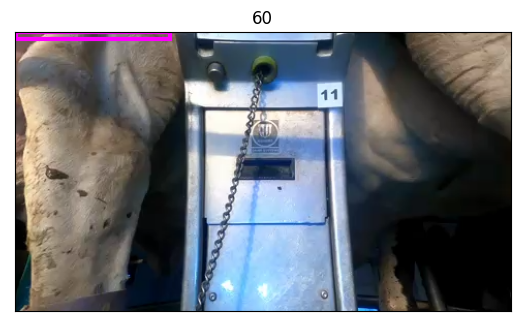

In [11]:
# Load the image
image = Image.open(image_path)

plot_class_bbox(image, label, bbox)

# 2. Train your model using [cow stall number datasets](https://github.com/YoushanZhang/Cow_stall_number)

#### __Path to the files__

In [9]:
data_path = "./data/Stall_num_images/"
train_csv = "./data/Train.csv"
test_csv = "./data/Test.csv"

In [11]:
# Function to convert the bounding box format
def convert_bbox_format(row):
    x, y, width, height = row['box_position_1'], row['box_position_2'], row['box_position_3'], row['box_position_4']
    xmin, xmax = x, x + width
    ymin, ymax = y, y + height
    return pd.Series([xmin, xmax, ymin, ymax], index=['xmin', 'xmax', 'ymin', 'ymax'])

In [12]:
# Read the CSV file
data = pd.read_csv(train_csv)

# Apply the conversion to each row of the dataset
new_bbox_data = data.apply(convert_bbox_format, axis=1)

# Combine the new bounding box data with the existing dataset
new_data = pd.concat([data['imageFilename'], new_bbox_data, data['class_names']], axis = 1)

# Save the transformed data to a new CSV file
new_data.to_csv('./data/transformed_Train.csv', index = False)

In [13]:
# Read the CSV file
data = pd.read_csv(test_csv)

# Apply the conversion to each row of the dataset
new_bbox_data = data.apply(convert_bbox_format, axis = 1)

# Combine the new bounding box data with the existing dataset
new_data = pd.concat([data['imageFilename'], new_bbox_data, data['class_names']], axis=1)

# Save the transformed data to a new CSV file
new_data.to_csv('./data/transformed_Test.csv', index = False)

In [10]:
train_csv = "./data/transformed_Train.csv"
test_csv = "./data/transformed_Test.csv"

#### __Dataloader parameters__

In [11]:
batch_size = 128

In [12]:
class ObjectDetectionDataset(Dataset):
    def __init__(self, csv_file, root_dir, image_size, augmentation = True, normilize = False, mean = [0.4490, 0.3818, 0.3154], std = [0.2956, 0.2707, 0.2677]):
        self.annotations = pd.read_csv(csv_file).fillna(0)
        self.root_dir = root_dir
        self.image_size = image_size
        self.augmentation = augmentation
        self. normilize = normilize
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        factor = 1.2

        img_path = self.root_dir + self.annotations.iloc[index, 0]
        image = cv2.imread(img_path)

        if image is None:
            raise ValueError(f"Unable to read image at path {img_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        image = Image.fromarray(image)  # Convert to PIL Image

        bbox = self.annotations.iloc[index, 1:5].values.astype('float')
        label = self.annotations.iloc[index, 5]

        # =======================  Resizing =======================
        original_width, original_height = image.size
        new_height, new_width = self.image_size

        if self.augmentation:
            scale_factor_width = new_width * factor / original_width
            scale_factor_height = new_height * factor / original_height
            image = transforms.Resize((int(new_height * factor), int(new_width * factor)))(image)

        else:
            scale_factor_width = new_width / original_width
            scale_factor_height = new_height / original_height
            image = transforms.Resize((new_height, new_width))(image)

        bbox[0] = scale_factor_width * bbox[0]
        bbox[1] = scale_factor_height * bbox[1]
        bbox[2] = scale_factor_width * bbox[2]
        bbox[3] = scale_factor_height * bbox[3]

        # ======================= Random Rotation =======================
        if self.augmentation:
            
            # Randomly rotate the image and bounding box
            angle = random.uniform(-20, 20)

            # Rotate the image
            image = transforms.functional.rotate(image, angle)

            # Rotate the bounding box
            center_x, center_y = image.width / 2, image.height / 2
            angle_rad = -angle * np.pi / 180
            cos_val, sin_val = np.cos(angle_rad), np.sin(angle_rad)

            xmin, xmax, ymin, ymax = bbox[0], bbox[1], bbox[2], bbox[3] 
            box_coords = np.array([[xmin, ymin], [xmin, ymax], [xmax, ymin], [xmax, ymax]])
            new_coords = np.zeros_like(box_coords)

            for i, coord in enumerate(box_coords):
                x_transf = coord[0] - center_x
                y_transf = coord[1] - center_y

                new_x = x_transf * cos_val - y_transf * sin_val + center_x
                new_y = x_transf * sin_val + y_transf * cos_val + center_y
                new_coords[i] = [new_x, new_y]

            xmin, ymin = np.min(new_coords, axis = 0)
            xmax, ymax = np.max(new_coords, axis = 0)
            bbox = np.array([xmin, xmax, ymin, ymax])

        # =======================  Random Cropping =======================
        if self.augmentation:
            i, j, h, w = transforms.RandomCrop.get_params(image, output_size = self.image_size)
            image = transforms.functional.crop(image, i, j, h, w)

            # Adjust bounding box coordinates
            bbox[0] = max(bbox[0] - j, 0)
            bbox[1] = max(bbox[1] - j, 0)
            bbox[2] = max(bbox[2] - i, 0)
            bbox[3] = max(bbox[3] - i, 0)

        # =======================  Random Horizontal Flip =======================
        if self.augmentation:
            flip_prob = random.random()  # Get a random probability

            if flip_prob < 0.35:  # If the probability is less than 0.35, apply horizontal flip
                # Flip the image
                image = transforms.functional.hflip(image)

                # Flip the bounding box
                img_width, _ = image.size
                xmin, xmax, ymin, ymax = bbox
                new_xmin = img_width - xmax
                new_xmax = img_width - xmin
                bbox = np.array([new_xmin, new_xmax, ymin, ymax])

        # =======================  Random Vertical Flip =======================
        if self.augmentation:
            flip_prob = random.random()

            if flip_prob < 0.1:  # Apply vertical flip with a probability of 0.1
                image = transforms.functional.vflip(image)

                # Flip the bounding box
                _, img_height = image.size
                xmin, xmax, ymin, ymax = bbox
                new_ymin = img_height - ymax
                new_ymax = img_height - ymin
                bbox = np.array([xmin, xmax, new_ymin, new_ymax])

        # =============  Random Brightness, Contrast, Saturation, and Hue =============
        if self.augmentation:
            image = transforms.ColorJitter(
                brightness = 0.2,  # Increase brightness variation
                contrast = 0.2,    # Add contrast variation
                saturation = 0.2,  # Add saturation variation
                hue = 0.1,
            )(image)


        # Convert image to tensor and normalize
        image = transforms.functional.to_tensor(image)
        
        if self.normilize:
            image = transforms.functional.normalize(image, mean = self.mean, std = self.std)

        return image, torch.tensor(bbox), label
        

In [13]:
def calculate_mean_std(loader):
    mean = torch.zeros(3)
    std = torch.zeros(3)
    total_images = 0

    for images, _, _ in loader:
        total_images += images.size(0)
        mean += images.sum(dim = (0, 2, 3))
        std += (images ** 2).sum(dim = (0, 2, 3))

    mean /= total_images * images.size(2) * images.size(3)
    std /= total_images * images.size(2) * images.size(3)
    std = torch.sqrt(std - mean ** 2)

    return mean, std

In [14]:
# Return a dictionary with the count of labels for each class
def count_labels(data_loader):
    class_counts = {}

    for images, bboxes, labels in data_loader:
        unique_labels, counts = torch.unique(labels, return_counts = True)
        for label, count in zip(unique_labels.tolist(), counts.tolist()):
            if label in class_counts:
                class_counts[label] += count
            else:
                class_counts[label] = count

    # Sort the class_counts dictionary by values (ascending order)
    sorted_class_counts = dict(sorted(class_counts.items(), key = lambda item: item[1]))

    return class_counts

In [15]:
def plot_label_distribution(class_counts, title):
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.bar(labels, counts)
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.title(title)
    plt.grid(linestyle = '--', linewidth = 0.5)
    plt.show()

#### __Training data__

In [16]:
original_train_dataset = ObjectDetectionDataset(train_csv, data_path, image_size, augmentation = False)
original_train_loader = DataLoader(original_train_dataset, batch_size = batch_size, shuffle = True)
print(f"Number of training samples : {len(original_train_dataset)}")
print(f"Number of batches in train DataLoader: {len(original_train_loader)}")

Number of training samples : 1042
Number of batches in train DataLoader: 9


In [17]:
# Distribution of training data into individual classes
original_train_label_counts = count_labels(original_train_loader)
print(original_train_label_counts)

{0: 182, 1: 15, 2: 17, 3: 19, 4: 18, 5: 16, 6: 11, 7: 15, 9: 10, 10: 13, 11: 14, 12: 15, 13: 16, 14: 22, 15: 14, 16: 11, 18: 12, 19: 11, 20: 16, 21: 14, 22: 11, 23: 14, 24: 14, 25: 13, 26: 18, 28: 28, 29: 11, 30: 17, 31: 19, 32: 14, 33: 10, 34: 11, 36: 11, 38: 15, 39: 8, 40: 7, 42: 15, 45: 18, 46: 14, 47: 13, 48: 16, 49: 13, 50: 13, 51: 12, 52: 14, 53: 15, 55: 19, 56: 16, 57: 14, 59: 17, 60: 9, 8: 14, 17: 11, 27: 11, 35: 10, 37: 15, 41: 17, 43: 12, 54: 17, 58: 18, 44: 17}


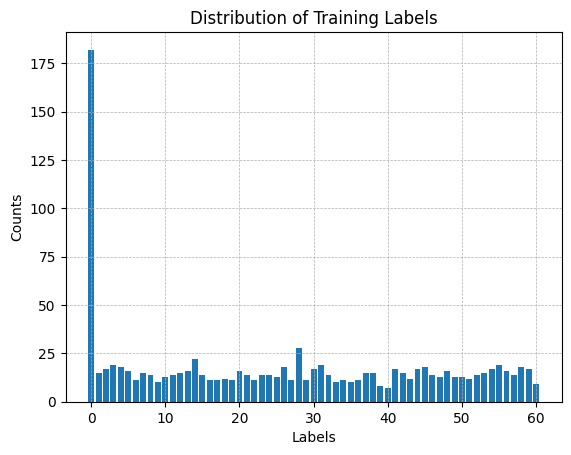

In [18]:
plot_label_distribution(original_train_label_counts, "Distribution of Training Labels")

In [19]:
train_dataset_1 = ObjectDetectionDataset(train_csv, data_path, image_size, augmentation = False)
train_dataset_2 = ObjectDetectionDataset(train_csv, data_path, image_size, augmentation = True)
train_dataset = ConcatDataset([train_dataset_1, train_dataset_2])
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
print(f"Number of training samples : {len(train_dataset)}")
print(f"Number of batches in train DataLoader: {len(train_loader)}")

Number of training samples : 2084
Number of batches in train DataLoader: 17


In [20]:
mean, std = calculate_mean_std(train_loader)
print(f"Mean: {mean}, Std: {std}")

Mean: tensor([0.4378, 0.3760, 0.3131]), Std: tensor([0.2915, 0.2728, 0.2672])


In [21]:
train_dataset_1 = ObjectDetectionDataset(train_csv, data_path, image_size, augmentation = False, normilize = True, mean = mean, std = std)
train_dataset_2 = ObjectDetectionDataset(train_csv, data_path, image_size, augmentation = True, normilize = True, mean = mean, std = std)
train_dataset = ConcatDataset([train_dataset_1, train_dataset_2])
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

In [22]:
norm_mean, norm_std = calculate_mean_std(train_loader)
print(f"Mean: {norm_mean}, Std: {norm_std}")

Mean: tensor([-8.2638e-05, -6.2003e-03, -3.7382e-04]), Std: tensor([1.0014, 0.9984, 1.0013])


In [23]:
# Distribution of training data into individual classes
train_label_counts = count_labels(train_loader)
print(train_label_counts)

{0: 364, 1: 30, 2: 34, 3: 38, 4: 36, 5: 32, 7: 30, 8: 28, 9: 20, 10: 26, 12: 30, 13: 32, 14: 44, 15: 28, 16: 22, 17: 22, 18: 24, 19: 22, 21: 28, 22: 22, 23: 28, 24: 28, 25: 26, 26: 36, 27: 22, 28: 56, 30: 34, 31: 38, 33: 20, 34: 22, 35: 20, 37: 30, 38: 30, 39: 16, 40: 14, 41: 34, 42: 30, 43: 24, 44: 34, 45: 36, 46: 28, 48: 32, 49: 26, 50: 26, 51: 24, 52: 28, 53: 30, 54: 34, 55: 38, 56: 32, 57: 28, 59: 34, 60: 18, 6: 22, 11: 28, 29: 22, 32: 28, 36: 22, 47: 26, 58: 36, 20: 32}


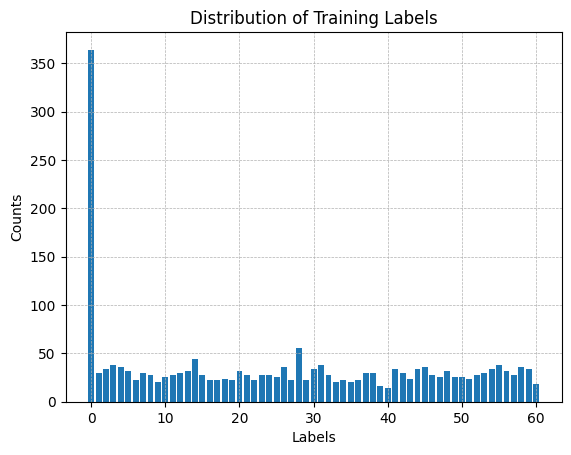

In [24]:
plot_label_distribution(train_label_counts, "Distribution of Training Labels")

#### __Test data__

In [25]:
test_dataset = ObjectDetectionDataset(test_csv, data_path, image_size, augmentation = False, normilize = True, mean = mean, std = std)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)
print(f"Number of training samples : {len(test_dataset)}")
print(f"Number of batches in validation DataLoader: {len(test_loader)}")

Number of training samples : 261
Number of batches in validation DataLoader: 3


In [26]:
# Distribution of test data into individual classes
test_label_counts = count_labels(test_loader)
print(test_label_counts)

{0: 43, 1: 4, 3: 3, 4: 1, 5: 5, 6: 4, 7: 2, 8: 2, 10: 5, 11: 5, 12: 5, 13: 2, 14: 4, 15: 4, 16: 6, 18: 6, 20: 3, 21: 4, 22: 3, 23: 2, 24: 2, 25: 3, 26: 2, 28: 7, 29: 5, 30: 2, 31: 8, 32: 2, 33: 4, 34: 5, 35: 6, 38: 4, 39: 2, 40: 2, 41: 4, 42: 3, 43: 5, 45: 2, 46: 3, 49: 3, 51: 7, 52: 3, 53: 6, 54: 5, 55: 2, 56: 4, 57: 5, 58: 3, 59: 2, 60: 5, 2: 1, 9: 6, 17: 4, 19: 1, 27: 2, 36: 4, 37: 2, 44: 2, 47: 4, 48: 2, 50: 4}


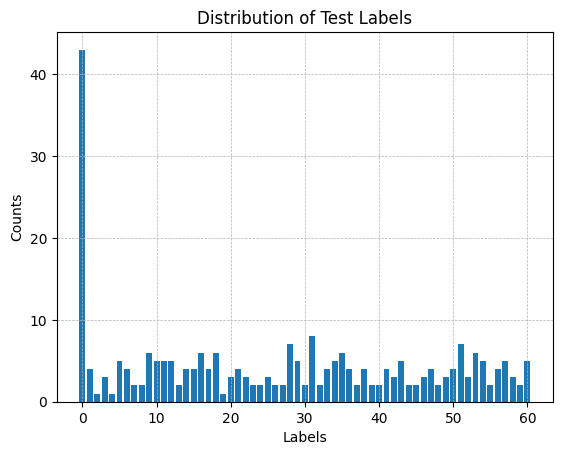

In [27]:
plot_label_distribution(test_label_counts, "Distribution of Test Labels")

#### __Test the functionality of the model on the dataset__

In [79]:
def test_images(model, dataloader):
    print("\n=== The Start of the test. ===\n")

    model.eval()  # Set the model to evaluation mode

    for idx, (images, bboxes, labels) in enumerate(dataloader):
        images = images.to(device)
        bboxes = bboxes.to(device)
        labels = torch.tensor(labels).to(device)
        
        with torch.no_grad():
            try:
                class_output, bbox_coords = model(images)
                print(f"Processed batch {idx + 1} successfully.")
            except Exception as e:
                print(f"Error processing batch {idx + 1}: {e}")

    # Release GPU memory cache
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        
    print("\n=== The test was successful! ===")

In [80]:
# Test all the images in the training dataset
test_images(model, train_loader)


=== The Start of the test. ===

Processed batch 1 successfully.
Processed batch 2 successfully.
Processed batch 3 successfully.
Processed batch 4 successfully.
Processed batch 5 successfully.
Processed batch 6 successfully.
Processed batch 7 successfully.
Processed batch 8 successfully.
Processed batch 9 successfully.
Processed batch 10 successfully.
Processed batch 11 successfully.
Processed batch 12 successfully.
Processed batch 13 successfully.
Processed batch 14 successfully.
Processed batch 15 successfully.
Processed batch 16 successfully.
Processed batch 17 successfully.

=== The test was successful! ===


In [27]:
# Test all the images in the test dataset
test_images(model, test_loader)


=== The Start of the test. ===

Processed batch 1 successfully.
Processed batch 2 successfully.
Processed batch 3 successfully.

=== The test was successful! ===


#### __Plot a sample of the training data__

In [64]:
def plot_images_with_bboxes(dataloader, mean = [0.4291, 0.3697, 0.3113], std = [0.2863, 0.2739, 0.2666], n_rows = 3, n_cols = 3):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

    # Make axs 2D if it's a 1D array
    if n_rows == 1:
        axs = axs[np.newaxis, :]
    
    for i in range(n_rows):
        for j in range(n_cols):
            # Get a random index from the dataset
            idx = random.randint(0, len(dataloader.dataset) - 1)
            
            # Get the image, bbox, and label at the random index
            image, bbox, label = dataloader.dataset[idx]
            
            # Convert the image tensor to a numpy array
            image_np = image.permute(1, 2, 0).numpy()
            
            # Unnormalize the image
            mean = mean#np.array([0.485, 0.456, 0.406])
            std = std#np.array([0.229, 0.224, 0.225])
            image_np = std * image_np + mean
            image_np = np.clip(image_np, 0, 1)
            
            # Plot the image
            axs[i, j].imshow(image_np)
            
            # Plot the bbox
            # print(bbox[0], bbox[1], bbox[2], bbox[3])
            xmin = bbox[0]
            xmax = bbox[1]
            ymin = bbox[2]
            ymax = bbox[3]


            rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                linewidth = 3,
                edgecolor ='#FF00FF',
                facecolor = 'none',
            )
            axs[i, j].add_patch(rect)
            
            # Set the title as the label
            axs[i, j].set_title(label)
            
            # Remove axis ticks
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])

    if n_rows == 1:
        plt.subplots_adjust(wspace = 0.05, hspace = 0.15)
    else:
        plt.subplots_adjust(wspace = 0.05, hspace = -0.5)
    plt.show()

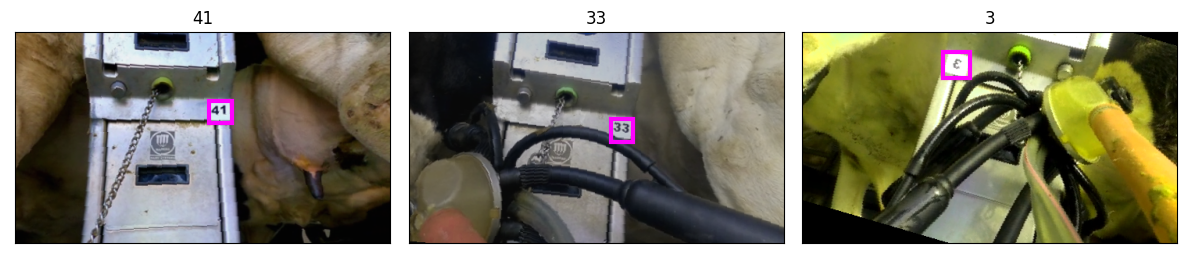

In [97]:
# Plot 1x3 grid of images with bounding boxes
plot_images_with_bboxes(train_loader, mean, std, n_rows = 1, n_cols = 3)

#### __Plot a sample of the test data__

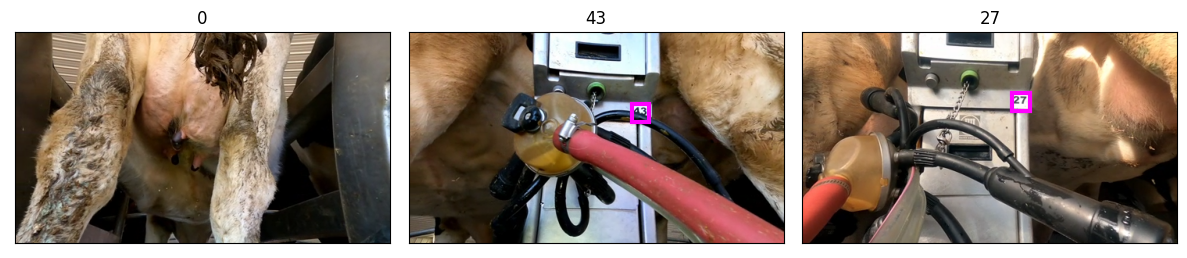

In [81]:
# Plot 1x3 grid of images with bounding boxes
plot_images_with_bboxes(test_loader, mean, std, n_rows = 1, n_cols = 3)

### __Training part__

In [28]:
# Pre-training preparation

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

In [29]:
def save_model(model, optimizer, epoch):

    # Make a timestamp
    time_stamp = datetime.now().timestamp()
    year_time = datetime.fromtimestamp(time_stamp).strftime("%Y-%m-%d_%H-%M-%S")

    # Create a folder
    saved_models_folder = "./saved_models"

    if not os.path.exists(saved_models_folder):
        os.makedirs(saved_models_folder)

    # Save the model:
    model_scripted = torch.jit.script(model) # Export to TorchScript
    model_name = model.__class__.__name__
    model_scripted.save('./saved_models/' +  model_name + '_' + str(epoch) + '_' + year_time + '.pt')

    # Save the model's state_dict (weights):
    model_name = model.__class__.__name__
    model_state = model.state_dict()
    torch.save(model_state, './saved_models/' + model_name + '_' + str(epoch) + '_' + year_time + '_weights.pth')

    # Save the optimizer state:
    optimizer_state = optimizer.state_dict()
    torch.save(optimizer_state, './saved_models/' +  model_name + '_' + 'optimizer' + '_' + str(epoch) + '_' + year_time + '.pth')

def load_model(file_name_model):
    saved_models_folder = "./saved_models/"

    model_path = saved_models_folder + file_name_model

    if not os.path.exists(model_path):
        raise FileNotFoundError(f"Model not found at '{model_path}'")
    
    model = torch.jit.load(model_path)

    return model

def load_weights(model, weights_file):
    saved_models_folder = "./saved_models/"
    weights_path = saved_models_folder + weights_file

    if not os.path.exists(weights_path):
        raise FileNotFoundError(f"Weights not found at '{weights_path}'")

    weights = torch.load(weights_path)
    model.load_state_dict(weights)
    return model

def load_optimizer(optimizer, optimizer_state_file):
    saved_models_folder = "./saved_models/"

    optimizer_state_path = saved_models_folder + optimizer_state_file

    if not os.path.exists(optimizer_state_path):
        raise FileNotFoundError(f"Optimizer state not found at '{optimizer_state_path}'")

    optimizer_state = torch.load(optimizer_state_path)
    optimizer.load_state_dict(optimizer_state)

In [30]:
def saveList(myList, filename, epoch):

    # Make a timestamp
    time_stamp = datetime.now().timestamp()
    year_time = datetime.fromtimestamp(time_stamp).strftime("%Y-%m-%d_%H-%M-%S")

    # Create a csv folder
    saved_models_folder = "./my_lists/"

    if not os.path.exists(saved_models_folder):
        os.makedirs(saved_models_folder)

    # the filename should mention the extension 'npy'
    path = saved_models_folder +  str(filename) + '_' + epoch + '_' + year_time + '.npy'

    np.save(path, myList)
    # print("Saved successfully!")

def loadList(filename):

    # the filename should mention the extension 'npy'
    path = './my_lists/' + str(filename)

    # the filename should mention the extension 'npy'
    tempNumpyArray = np.load(path)
    return tempNumpyArray.tolist()

In [31]:
# Define the loss function and optimizer
class MultiTaskLoss(nn.Module):
    def __init__(self, alpha = 0.1):
        super(MultiTaskLoss, self).__init__()
        self.alpha = alpha
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.smooth_l1_loss = nn.SmoothL1Loss(reduction = 'none')

    def forward(self, cls_preds, cls_targets, loc_preds, loc_targets):
        # Classification loss (Cross-Entropy loss)
        cls_loss = self.cross_entropy_loss(cls_preds, cls_targets)
        # print("Classification loss:", cls_loss.item())

        # Localization loss (Smooth L1 loss)
        loc_loss = self.smooth_l1_loss(loc_preds, loc_targets)
        mask = (loc_loss != 0) # Exclude the background class (class 0)
        loc_loss = loc_loss[mask].mean()  # Apply the mask and compute the mean of the remaining values
        # print("Localization loss:", loc_loss.item())

        # Multi-task loss
        loss = cls_loss + self.alpha * loc_loss

        return loss

In [32]:
# Hyper-parameters
num_epochs = 300

learning_rate = 5e-5

# True for loading old model, False for a fresh model
load_lists_model = False

#### __Setting Up Transfer Learning__

In [33]:
# First, freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last 3 layers of the feature_extractor
layers_to_unfreeze = 3
num_layers = len(list(model.feature_extractor.children()))
for i, layer in enumerate(model.feature_extractor.children()):
    if i >= num_layers - layers_to_unfreeze:
        for param in layer.parameters():
            param.requires_grad = True

# Unfreeze all the layers of the classifier
for param in model.classifier.parameters():
    param.requires_grad = True

# Unfreeze all the layers of the bbox_regressor
for param in model.bbox_regressor.parameters():
    param.requires_grad = True

In [34]:
# Optimizer
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr = learning_rate, weight_decay = 5e-4)
# optimizer = optim.Adam(model.parameters(), lr = learning_rate)#, weight_decay = 5e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)

In [35]:
if load_lists_model:
    loss_values_train = loadList("loss_values_train_50_2023-04-14_21-43-42.npy")
    loss_values_val = loadList("loss_values_val_50_2023-04-14_21-43-42.npy")
    accuracy_train = loadList("accuracy_train_50_2023-04-14_21-43-42.npy")
    accuracy_val = loadList("accuracy_val_50_2023-04-14_21-43-42.npy")
    history_learning_rate = loadList("history_learning_rate_50_2023-04-14_21-43-42.npy")
    # iou_train = loadList("history_learning_rate_50_2023-04-14_21-43-42.npy")
    # iou_val = loadList("history_learning_rate_50_2023-04-14_21-43-42.npy")
    print_messages = loadList("print_messages_50_2023-04-14_21-43-42.npy")
    
    current_epoch = len(loss_values_train)
    starting_epoch = current_epoch + 1
    print(f"Current epoch : {current_epoch}")
    print(f"Starting epoch : {starting_epoch}")

    # Load the model
    model = load_model("MyObjectDetector_50_2023-04-14_21-43-40.pt").to(device)

    # Model Parameters
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} model parameters")

    print(f"Is my model in GPU? : {next(model.parameters()).is_cuda}")

    # GPU memory cache size
    if torch.cuda.is_available():
        print(f"The allocated memory in the GPU for the model : {torch.cuda.memory_allocated()/(1024 * 1024):.3f}MB")

    # Load the optimizer state
    load_optimizer(optimizer, "MyObjectDetector_optimizer_50_2023-04-14_21-43-40.pth")
        
else:
    loss_values_train = []
    loss_values_val = []
    accuracy_train = []
    accuracy_val = []
    history_learning_rate = []
    # iou_train = []
    # iou_val = []
    print_messages = []
    current_epoch = 0
    starting_epoch = current_epoch + 1
    print(f"Current epoch : {current_epoch}")
    print(f"Starting epoch : {starting_epoch}")

Current epoch : 0
Starting epoch : 1


In [36]:
# Loss function
# Instantiate the multi-task loss function
class_reg_loss = MultiTaskLoss()

In [37]:
def update_plots(loss_values_train, loss_values_val, accuracy_train, accuracy_val, print_messages):
    clear_output(wait = True)

    # Display print messages
    for message in print_messages:
        print(message)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))
    
    # Plot loss values
    ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = 'Train Loss')
    ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = 'Validation Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.set_title('Loss values')
    ax1.grid(linestyle = '--', linewidth = 0.5)

    # Plot accuracy values
    ax2.plot(range(1, len(accuracy_train) + 1), accuracy_train, label = 'Train Accuracy')
    ax2.plot(range(1, len(accuracy_val) + 1), accuracy_val, label = 'Validation Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.set_title('Accuracy values')
    ax2.grid(linestyle = '--', linewidth = 0.5)

    plt.show()


	 ****** Training has begun. ******

Initial learning rate : 5e-05
Epoch: 001 / 300, Train Loss: 0.1529842997, Validation Loss: 0.2165209014, Train Accuracy: 15.36%, Validation Accuracy: 16.48%, Time: 10:47:47
Epoch: 002 / 300, Train Loss: 0.1424176514, Validation Loss: 0.2004291710, Train Accuracy: 17.47%, Validation Accuracy: 16.48%, Time: 10:48:36
Epoch: 003 / 300, Train Loss: 0.1359481752, Validation Loss: 0.1982516950, Train Accuracy: 17.71%, Validation Accuracy: 16.48%, Time: 10:49:26
Epoch: 004 / 300, Train Loss: 0.1326491403, Validation Loss: 0.1955201452, Train Accuracy: 18.33%, Validation Accuracy: 17.24%, Time: 10:50:16
Epoch: 005 / 300, Train Loss: 0.1321930565, Validation Loss: 0.1997396571, Train Accuracy: 18.86%, Validation Accuracy: 18.39%, Time: 10:51:07
Epoch: 006 / 300, Train Loss: 0.1307689507, Validation Loss: 0.1954871430, Train Accuracy: 19.67%, Validation Accuracy: 18.77%, Time: 10:51:57
Epoch: 007 / 300, Train Loss: 0.1305491471, Validation Loss: 0.1933741259,

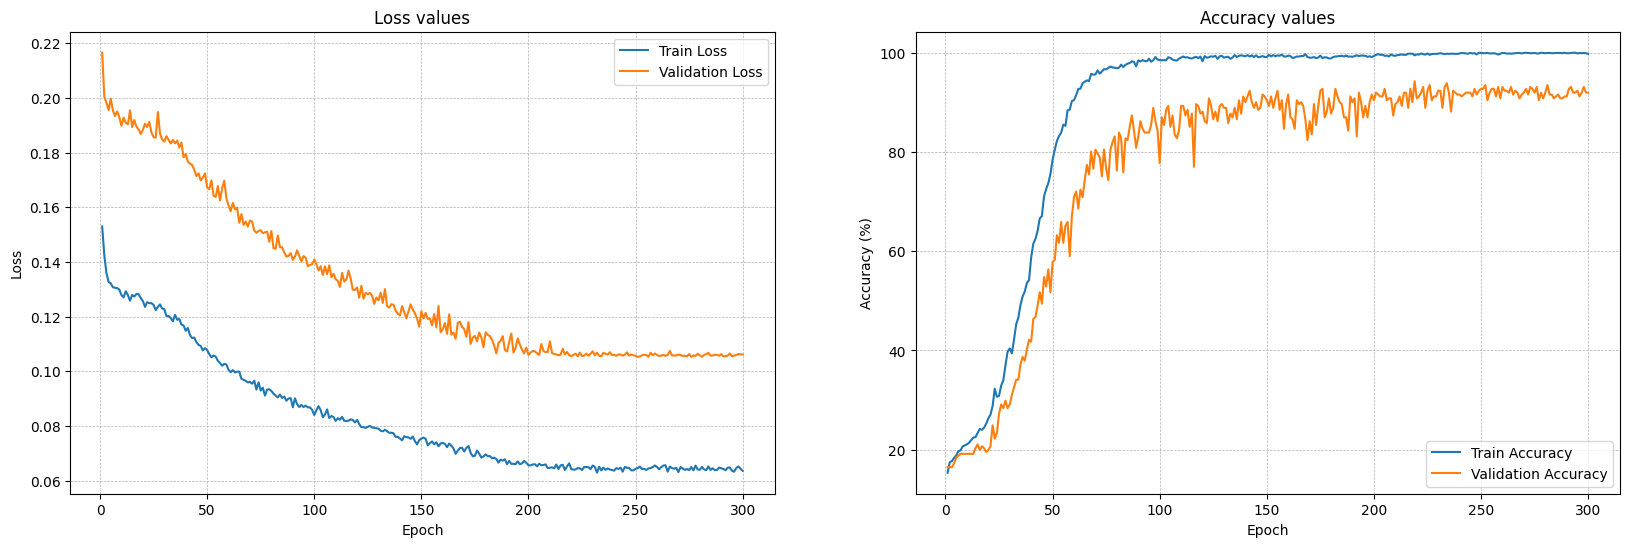

In [38]:
# Training process
start = timer()

message = '\n\t ****** Training has begun. ******\n'
print_messages.append(message)

message = f"Initial learning rate : {optimizer.param_groups[0]['lr']}"
print_messages.append(message)

# Update the plots
update_plots(loss_values_train, loss_values_val, accuracy_train, accuracy_val, print_messages)

for epoch in range(starting_epoch, num_epochs + 1):

    ########################## TRAINING ###############################
    # Set the network to training mode
    model.train()
    history_learning_rate.append(optimizer.param_groups[0]['lr'])

    train_correct = 0
    train_total = 0
    train_loss = 0


    # Iterate over the batches of training data
    for images, box_target, class_target in train_loader:
      
        box_target = box_target.to(torch.float32)
        images, class_target, box_target = images.to('cuda'), class_target.to('cuda'), box_target.to('cuda')

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Pass the images through the model (Forward pass)
        class_pred, box_pred = model(images)

        # Calculate accuracy
        train_total += class_target.size(0)
        _, train_predicted = torch.max(class_pred.data, 1)
        train_correct += (train_predicted == class_target).sum().item()

        # Compute the loss based on the targets
        loss_train = class_reg_loss(class_pred, class_target, box_pred, box_target)
        # loss_train = class_reg_loss(class_pred, class_target)

        # Accumulate loss
        train_loss += loss_train.item()

        # Backward pass and optimization
        loss_train.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # Gradient Clipping
        optimizer.step()

    # Add loss and acc to history
    loss_values_train.append(train_loss / train_total)
    train_acc = (100 * train_correct) / train_total
    accuracy_train.append(train_acc)

    ########################## VALIDATION ###############################
    # Set the network to testing validation
    model.eval()
    
    val_correct = 0
    val_total = 0
    val_loss = 0

    with torch.no_grad():
        for images, box_target, class_target in test_loader:
            
            box_target = box_target.to(torch.float32)
            images, class_target, box_target = images.to('cuda'), class_target.to('cuda'), box_target.to('cuda')

            # Pass the images through the model (Forward pass)
            class_pred, box_pred = model(images)

            # Calculate accuracy
            val_total += class_target.size(0)
            _, val_predicted = torch.max(class_pred.data, 1)
            val_correct += (val_predicted == class_target).sum().item()

            # Compute the loss based on the targets
            loss_val = class_reg_loss(class_pred, class_target, box_pred, box_target)
            # loss_val = class_reg_loss(class_pred, class_target)

            # Accumulate loss
            val_loss += loss_val.item()

    # Add loss and acc to history
    loss_values_val.append(val_loss / val_total)
    val_acc = (100 * val_correct) / val_total
    accuracy_val.append(val_acc)


    # Add IoU to history
    # iou_train.append(evaluate_model_iou(model,train_loader))
    # iou_val.append(evaluate_model_iou(model, test_loader))

    # Print training statistics
    time_stamp = datetime.now().timestamp()
    current_time = datetime.fromtimestamp(time_stamp).strftime("%H:%M:%S")
    message = f"Epoch: {epoch:03} / {num_epochs:03}, Train Loss: {loss_values_train[-1]:.10f}, Validation Loss: {loss_values_val[-1]:.10f}, Train Accuracy: {accuracy_train[-1]:.2f}%, Validation Accuracy: {accuracy_val[-1]:.2f}%, Time: {current_time}"# Train IoU: {iou_train[-1]:.4f}%, Validation IoU: {iou_val[-1]:.4f}%"
    print_messages.append(message)

    if epoch % 20 == 0:
        # Every 20th epoch, the learning rate is reduced to 85%
        current_learning_rate = optimizer.param_groups[0]['lr']
        new__learning_rate = current_learning_rate * 0.85
        optimizer.param_groups[0]['lr'] = new__learning_rate
        message = f"Old learning rate : {current_learning_rate}, New learning rate: {new__learning_rate}"
        print_messages.append(message)

    # Update the plots
    update_plots(loss_values_train, loss_values_val, accuracy_train, accuracy_val, print_messages)

    if (epoch % 50 == 0) or (accuracy_val[-1] >= 80.0):
        save_model(model, optimizer, str(epoch))
        saveList(loss_values_train,'loss_values_train', str(epoch))
        saveList(loss_values_val,'loss_values_val', str(epoch))
        saveList(accuracy_train,'accuracy_train', str(epoch))
        saveList(accuracy_val,'accuracy_val', str(epoch))
        saveList(history_learning_rate,'history_learning_rate', str(epoch))
        # saveList(iou_train,'iou_train', str(epoch))
        # saveList(iou_val,'iou_val', str(epoch))
        saveList(print_messages,'print_messages', str(epoch))

    


end = timer()
message = '\n\n\t ****** Training has finished. ******\n'
print_messages.append(message)
print(message)
message = f'\tTraining time: {timedelta(seconds=end-start)} [hh:mm:ss]'
print_messages.append(message)
print(message)

# Update the plots
update_plots(loss_values_train, loss_values_val, accuracy_train, accuracy_val, print_messages)

# Release GPU memory cache
if torch.cuda.is_available():
    torch.cuda.empty_cache()

current_epoch = epoch
starting_epoch = current_epoch + 1
# print(f"Current epoch : {current_epoch}")
# print(f"Starting epoch : {starting_epoch}")


#### __Plot of the Loss and the Accuracy History__

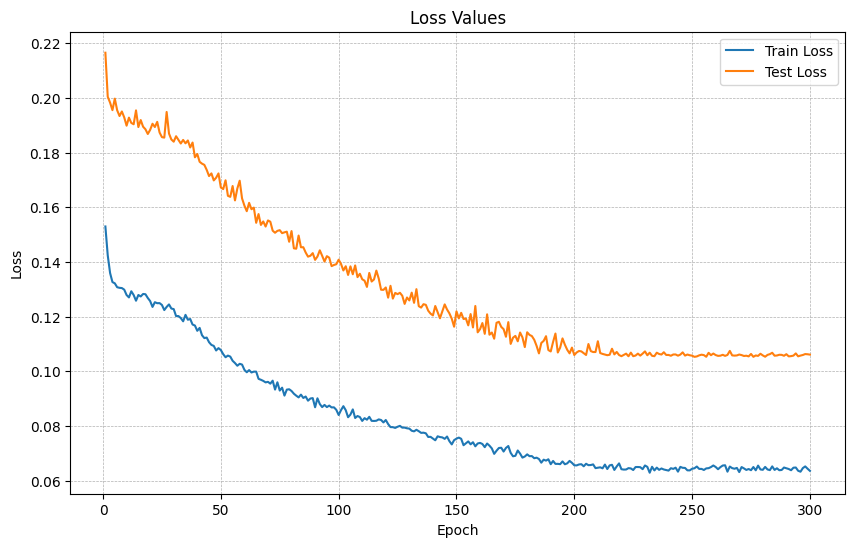

In [46]:
# Create the first plot for loss values
fig1, ax1 = plt.subplots(figsize = (10, 6))

ax1.plot(range(1, len(loss_values_train) + 1), loss_values_train, label = 'Train Loss')
ax1.plot(range(1, len(loss_values_val) + 1), loss_values_val, label = 'Test Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('Loss Values')
ax1.grid(linestyle='--', linewidth=0.5)

plt.show()

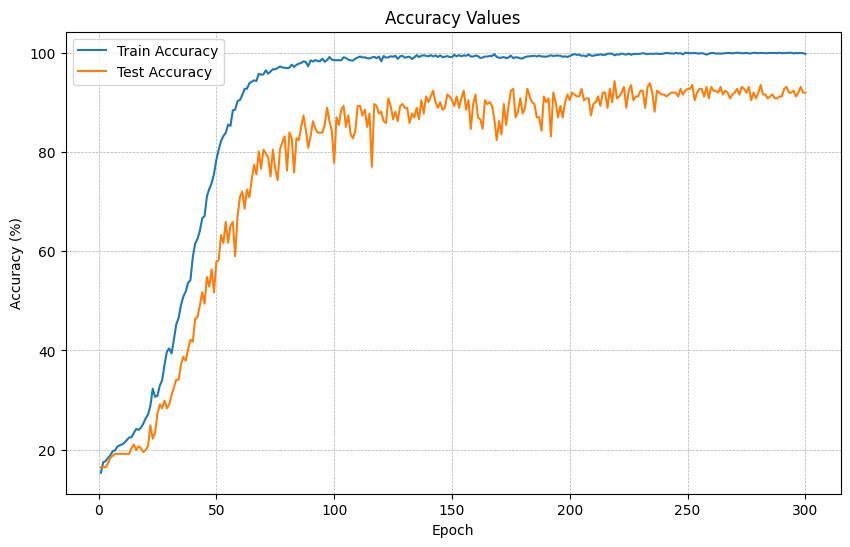

In [45]:
# Create the second plot for accuracy values
fig2, ax2 = plt.subplots(figsize = (10, 6))

ax2.plot(range(1, len(accuracy_train) + 1), accuracy_train, label = 'Train Accuracy')
ax2.plot(range(1, len(accuracy_val) + 1), accuracy_val, label = 'Test Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.set_title('Accuracy Values')
ax2.grid(linestyle='--', linewidth=0.5)

plt.show()

#### __History of the Learning Rate__

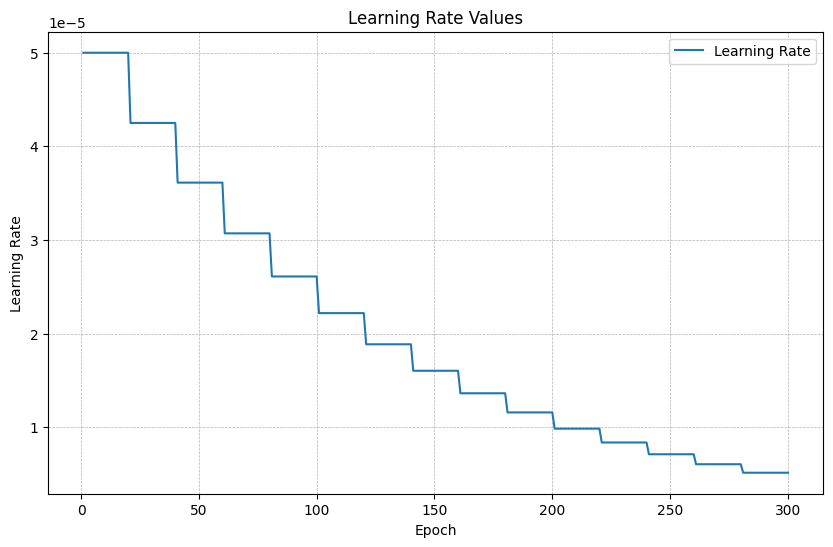

In [44]:
# Plot learning rate values
plt.figure(figsize = (10, 6))
plt.plot(range(1, len(history_learning_rate) + 1), history_learning_rate, label = 'Learning Rate')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.legend()
plt.title('Learning Rate Values')
plt.grid(linestyle = '--', linewidth = 0.5)

plt.show()

# 3. Evaluate your model using the test images

#### __Intersection over Union (IoU)__

In [47]:
# IoU (Intersection over Union) calculation function
def calculate_iou(pred_box, gt_boxes):
    xA = max(pred_box[0], gt_boxes[:, 0])
    xB = min(pred_box[1], gt_boxes[:, 1])
    yA = max(pred_box[2], gt_boxes[:, 2])
    yB = min(pred_box[3], gt_boxes[:, 3])

    inter_area = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    pred_box_area = (pred_box[2] - pred_box[0] + 1) * (pred_box[3] - pred_box[1] + 1)
    gt_boxes_area = (gt_boxes[:, 2] - gt_boxes[:, 0] + 1) * (gt_boxes[:, 3] - gt_boxes[:, 1] + 1)

    iou = inter_area / (pred_box_area + gt_boxes_area - inter_area)
    return iou.max()

In [48]:
def evaluate_model_iou(model, dataloader):
    model.eval()
    total_iou = 0
    num_samples = 0

    with torch.no_grad():
        for images, gt_boxes, gt_classes in dataloader:
            images = images.to(device)
            gt_boxes = gt_boxes.to(device)

            # Pass the images through the model (Forward pass)
            class_pred, bbox_pred = model(images)

            # Iterate over each predicted box and ground truth box in the batch
            for pred_box, gt_box in zip(bbox_pred, gt_boxes):
                # Expand the dimensions of gt_box to match the calculate_iou function's requirements
                gt_box_expanded = gt_box.unsqueeze(0)
                iou = calculate_iou(pred_box, gt_box_expanded)
                total_iou += iou
                num_samples += 1

    # Calculate the average IOU
    average_iou = total_iou / num_samples
    return average_iou

In [49]:
average_iou = evaluate_model_iou(model, test_loader)
print(f"Average IOU: {average_iou:.4f}")

Average IOU: 0.1850


In [160]:
def plot_images_with_bboxes(model, dataloader, mean=[0.4291, 0.3697, 0.3113], std=[0.2863, 0.2739, 0.2666], n_rows=1, n_cols=3):
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))

    messages = []

    for i in range(n_cols):
        # Get a random index from the dataset
        idx = random.randint(0, len(dataloader.dataset) - 1)

        # Get the image, bbox, and label at the random index
        image, bbox, label = dataloader.dataset[idx]
        image = image.unsqueeze(0).to('cuda')

        # Get predictions
        class_pred, bbox_pred = model(image)
        class_pred = torch.argmax(class_pred, dim=1).item()
        bbox_pred = bbox_pred.squeeze().detach().cpu().numpy()

        # Convert the image tensor to a numpy array
        image_np = image.squeeze().permute(1, 2, 0).cpu().numpy()

        # Unnormalize the image
        mean = np.array(mean)
        std = np.array(std)
        image_np = std * image_np + mean
        image_np = np.clip(image_np, 0, 1)

        # Predictions
        axs[i].imshow(image_np)
        xmin, xmax, ymin, ymax = bbox_pred
        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=3,
                                 edgecolor='#FF00FF',
                                 facecolor='none')
        axs[i].add_patch(rect)
        axs[i].set_title(f"Predicted class: {class_pred}")
        axs[i].set_xticks([])
        axs[i].set_yticks([])

        messages.append(f"True class: {label}, BBox: [{bbox[0]:.2f}, {bbox[1]:.2f}, {bbox[2]:.2f}, {bbox[3]:.2f}]")
        messages.append(f"Predicted class: {class_pred}, BBox: [{xmin:.2f}, {xmax:.2f}, {ymin:.2f}, {ymax:.2f}]")

    for message in messages:
        print(message )


    plt.subplots_adjust(wspace=0.05, hspace=-0.7)
    plt.show()


True class: 54, BBox: [279.00, 302.00, 96.00, 119.00]
Predicted class: 54, BBox: [103.36, 125.17, 103.36, 125.17]
True class: 52, BBox: [296.00, 321.00, 79.00, 100.00]
Predicted class: 52, BBox: [85.67, 104.47, 85.67, 104.47]
True class: 57, BBox: [93.00, 120.00, 107.00, 128.00]
Predicted class: 7, BBox: [89.35, 108.36, 89.35, 114.13]


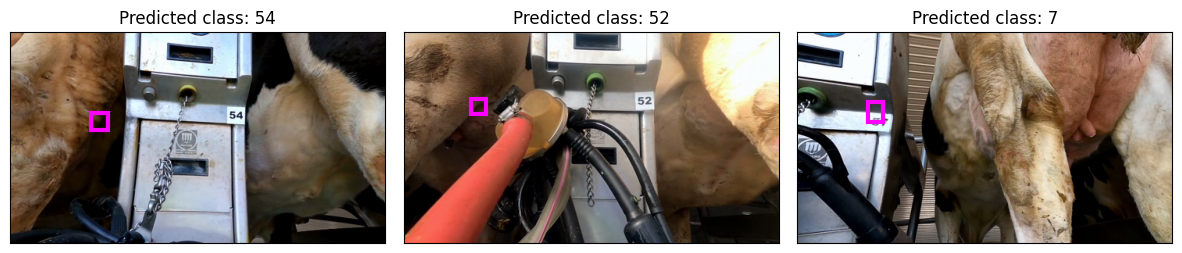

In [161]:
plot_images_with_bboxes(model, test_loader)

# 4. Your results should be higher than 80%.

In [50]:
def evaluate_model_accuracy(model, dataloader, device):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, gt_boxes, gt_classes in dataloader:
            images = images.to(device)
            gt_classes = gt_classes.to(device)

            # Pass the images through the model (Forward pass)
            class_pred, bbox_pred = model(images)

            # Calculate accuracy
            total_samples += gt_classes.size(0)
            _, predicted_classes = torch.max(class_pred.data, 1)
            total_correct += (predicted_classes == gt_classes).sum().item()

    # Calculate the test accuracy
    accuracy = (total_correct / total_samples) * 100
    return accuracy

In [51]:
test_accuracy = evaluate_model_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.95%


# 5. Write a four-page report using LaTex and upload your paper to ResearchGate or Arxiv, and put your paper link here.

https://www.researchgate.net/publication/370150950_Detection_and_Localization_of_Stall_Numbers_Using_Deep_CNN

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file, and add paper link)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points

# References

- How to Use a Pretrained ResNet Model in PyTorch : https://reason.town/resnet-pretrained-model-pytorch/

- Datasets & DataLoaders : https://pytorch.org/tutorials/beginner/basics/data_tutorial.html

- Concatenating datasets : https://www.oreilly.com/library/view/deep-learning-with/9781789534092/5f2cf6d8-4cdf-4e83-8c5b-58fbf722f6b6.xhtml

- Performing Image Augmentation using Pytorch : https://datamahadev.com/performing-image-augmentation-using-pytorch/

- PyTorch: How do the means and stds get calculated in the Transfer Learning tutorial? : https://stackoverflow.com/questions/48818619/pytorch-how-do-the-means-and-stds-get-calculated-in-the-transfer-learning-tutor

- Normalize images with transform in pytorch dataloader : https://xydida.com/2022/9/11/ComputerVision/Normalize-images-with-transform-in-pytorch-dataloader/

- Tuning Adam Optimizer Parameters in PyTorch : https://www.kdnuggets.com/2022/12/tuning-adam-optimizer-parameters-pytorch.html

- Intersection over Union (IoU) in Object Detection & Segmentation : https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/